## Import
Use elements of the scientific python stack

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr

# Import ast which helps with parsing the list of variables
import ast

# Import intake-esm
import intake

# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

%matplotlib inline

## Setup a PBSCluster
Speed up processing with DASK with 8 threads

In [2]:

cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='CESM0002', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

cluster.scale(8) # Scale up

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/marsh/miniconda3/envs/default/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42787 instead
  warnings.warn(


In [3]:
client

<Client: 'tcp://10.12.206.46:42591' processes=8 threads=8, memory=74.48 GiB>

## Open a catalog

In [24]:
col = intake.open_esm_datastore(
    "/glade/work/marsh/intake-esm-catalogs/waccm_1deg_MA_BWma1850.json",
)
col

,unique
component,1
stream,1
case,1
member_id,0
variable,315
start_time,4
end_time,4
time_range,4
long_name,305
units,50


In [27]:
cat = col.search(
    variable=('U','V','T'),
)
cat

,unique
component,1
stream,1
case,1
member_id,0
variable,3
start_time,4
end_time,4
time_range,4
long_name,3
units,2


In [28]:

dsets = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 8}, 'decode_times': False})



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'


In [29]:
dsets

{'atm.cam.h0.b.e21.BWma1850.f09_g17.release-cesm2.1.3.c20200918': <xarray.Dataset>
 Dimensions:       (ilev: 71, lat: 192, lev: 70, lon: 288, nbnd: 2, time: 1836, zlon: 1)
 Coordinates:
   * time          (time) float64 31.0 59.0 90.0 ... 5.581e+04 5.584e+04
   * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
   * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
   * zlon          (zlon) float64 0.0
   * lev           (lev) float64 5.96e-06 9.827e-06 1.62e-05 ... 976.3 992.6
   * ilev          (ilev) float64 4.5e-06 7.42e-06 1.223e-05 ... 985.1 1e+03
 Dimensions without coordinates: nbnd
 Data variables: (12/29)
     gw            (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
     zlon_bnds     (zlon, nbnd) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
     hyam          (lev) float64 dask.array<chunksize=(70,), meta=np.ndarray>
     hybm          (lev) float64 dask.array<chunksize=(70,), meta=np.ndarray>
     

In [30]:
k = 'atm.cam.h0.b.e21.BWma1850.f09_g17.release-cesm2.1.3.c20200918'
print(k)

ds = dsets[k]
ds = xr.decode_cf(ds)
print(ds['time'][0])
ds = ds.sortby('time')
print(ds['time'][0])
u1 = ds['U'].sel(lat=0.0, lev=30.0, method='nearest').mean(dim='lon')



atm.cam.h0.b.e21.BWma1850.f09_g17.release-cesm2.1.3.c20200918
<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(110, 2, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 0110-02-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds
<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(110, 2, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 0110-02-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds


In [10]:
u1

<xarray.DataArray 'U' (time: 1836)>
dask.array<mean_agg-aggregate, shape=(1836,), dtype=float32, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 0.4712
    lev      float64 29.73
  * time     (time) object 0110-02-01 00:00:00 ... 0263-01-01 00:00:00

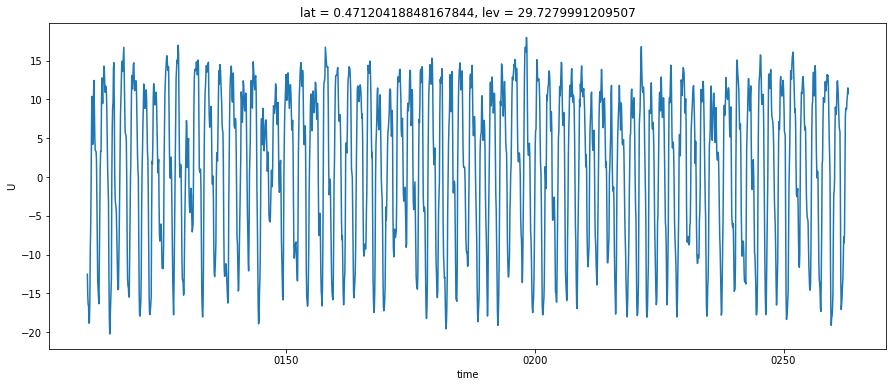

In [17]:
# data looks reasonable as values
plt.figure(figsize=(15,6))

u1.plot()

plt.show()

In [18]:
u1

<xarray.DataArray 'U' (time: 1836)>
dask.array<mean_agg-aggregate, shape=(1836,), dtype=float32, chunksize=(8,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 0.4712
    lev      float64 29.73
  * time     (time) object 0110-02-01 00:00:00 ... 0263-01-01 00:00:00

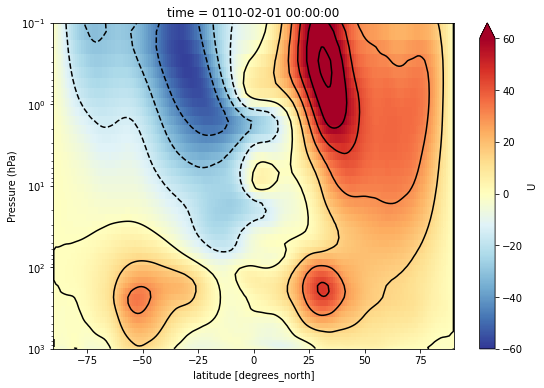

In [19]:
# time recognized when a single time is extracted
u0 =  ds['U'].isel(time=0).mean(dim='lon')
fig = u0.plot(cmap='RdYlBu_r', figsize=(9,6), 
              ylim=(1000,0.1), 
              vmin=-60, vmax=60
              )
u0.plot.contour(yincrease=False, colors='black', levels=np.arange(-90,91,15))

fig.axes.set_yscale('log')
fig.axes.set_ylabel('Pressure (hPa)')
plt.show()

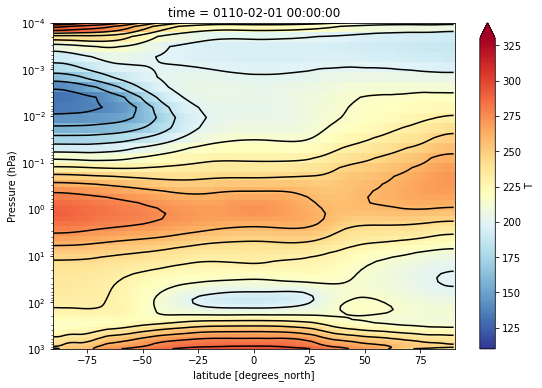

In [34]:
# time recognized when a single time is extracted
t0 =  ds['T'].isel(time=0).mean(dim='lon')
fig = t0.plot(cmap='RdYlBu_r', figsize=(9,6), 
              ylim=(1000,0.0001), 
              vmin=110, vmax=330
              )
t0.plot.contour(yincrease=False, colors='black', levels=np.arange(110,350,15))

fig.axes.set_yscale('log')
fig.axes.set_ylabel('Pressure (hPa)')
plt.show()